# HW03: Embeddings

In [1]:
# Import Libraries
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim import models
from gensim import similarities

from sklearn.decomposition import PCA

## Simpsons Dataset

### Import training data

In [2]:
# Import data
simpsons_docs = []

# Open and read file
with open('./data/simpsons/X_train.csv', 'r') as read_obj:
    for row in csv.reader(read_obj):
        simpsons_docs.append(row)
        
# Glimpse at training docs
for i in range(0,10):
    print(simpsons_docs[i])

['lisa', 'dish', 'pick', 'chore', 'hat', 'practice', 'see', 'is', 'practice', 'work']
['worry', 'got', 'man', 'perimeter']
['snowball']
['oh', 'yeah', 'way', 'off']
['oh', 'beautiful', 'oh', 'oh', 'let', 'bart', 's', 'beautiful', 'drawing', 'fridge']
['you', 're', 'halfway', 'home', 'lady']
['uh', 'hello']
['got', 'idea', 'regular', 'pen']
['teach', 'way']
['heh', 'heh', 'heh', 'moe', 'leader']


### Word2Vec Embeddings

In [3]:
# Define Word2Vec Embeddings
simpsons_w2v_model_150 = models.Word2Vec(simpsons_docs, size=150, window=3, min_count=20, sg=1, negative=10, workers=10)
simpsons_w2v_model_75 = models.Word2Vec(simpsons_docs, size=75, window=3, min_count=20, sg=1, negative=10, workers=10)
simpsons_w2v_model_15 = models.Word2Vec(simpsons_docs, size=15, window=3, min_count=20, sg=1, negative=10, workers=10)

# Train Word2Vec Embeddings
simpsons_w2v_model_150.train(simpsons_docs, total_examples=len(simpsons_docs), epochs=20)
simpsons_w2v_model_75.train(simpsons_docs, total_examples=len(simpsons_docs), epochs=20)
simpsons_w2v_model_15.train(simpsons_docs, total_examples=len(simpsons_docs), epochs=20)

(2948754, 4500000)

In [4]:
# Save W2V Embeddings
simpsons_w2v_model_150.save("./resources/embeddings/Simpsons_150_7.model")
simpsons_w2v_model_75.save("./resources/embeddings/Simpsons_75_7.model")
simpsons_w2v_model_15.save("./resources/embeddings/Simpsons_15_7.model")

In [5]:
len(simpsons_w2v_model_150.wv.vocab)

1552

### 2D Plots

In [6]:
def plot_similar_words(words, model, subplot_size = [2,2], xlim=[-5,5], ylim=[-5,5]):
    
    fig = plt.figure(figsize=(15, 12))
    fig.suptitle('Most similar words to:', fontsize=20)
    
    # Loop over the words
    for i, word in enumerate(words):
        
        # Retrieve similar words
        most_similar = model.wv.most_similar(positive=[word])

        similar_words = [word]
        for w in most_similar:
            similar_words.append(w[0])

        # Create PCA object with 2 components
        pca = PCA(n_components=2)

        # Extract embeddings from model
        vocab = list(model.wv.vocab)
        X = model.wv[vocab]

        # Fit PCA with all embeddings vocab
        pca.fit(X)

        # Transform similar words
        X_pca = pca.transform(model.wv[similar_words])

        # Plot
        df = pd.DataFrame(X_pca, index=similar_words, columns=['x', 'y'])
        
        plt.subplot(subplot_size[0], subplot_size[1], i+1)
        plt.title(str(word), fontsize=18)
        plt.grid(True)
        plt.xlim(xlim)
        plt.ylim(ylim)

        plt.scatter(df['x'], df['y'], s=100, c='b', alpha=0.25)
        plt.scatter(df['x'][0], df['y'][0], s=100, c='r', alpha=0.25)
        for word, pos in df.iterrows():
            plt.annotate(word, pos, fontsize=11)


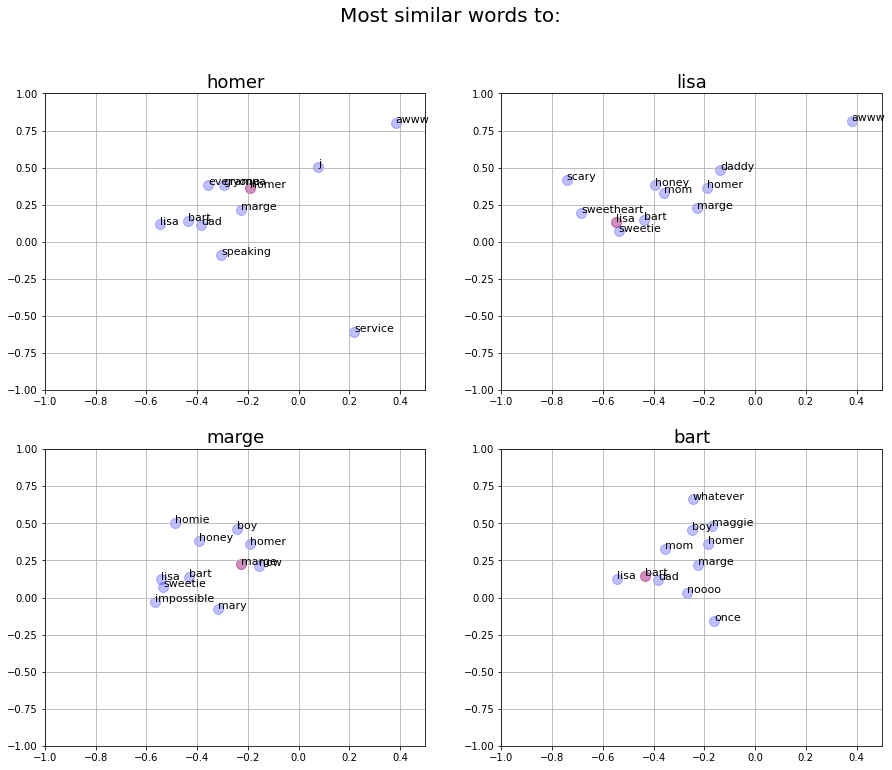

In [40]:
simpsons_characters = ['homer', 'lisa', 'marge', 'bart']
plot_similar_words(simpsons_characters, simpsons_w2v_model_75, subplot_size = [2,2], xlim=[-1,0.5], ylim=[-1,1])

### Relations

#### Similarity

How similar are two words?

In [8]:
def get_similarity_matrix(w2v_model, word_list):
    
    # Init matrix
    matrix = np.zeros((len(word_list),len(word_list)))
    
    # Get similarity between all words
    for i, wi in enumerate(word_list):
        for j, wj in enumerate(word_list):
            matrix[i][j] = w2v_model.wv.similarity(wi, wj)
            
    return matrix
        

In [9]:
# Get similarity matrix
word_list = ['homer', 'marge', 'bart', 'lisa', 'maggie', 'husband', 'wife', 'brother', 'sister', 'baby']
sim_matrix = get_similarity_matrix(simpsons_w2v_model_150, word_list)

<AxesSubplot:>

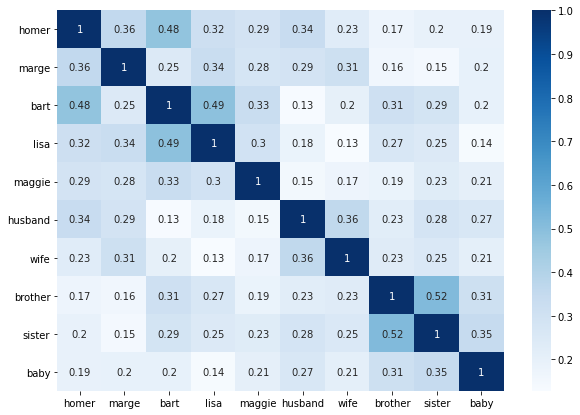

In [10]:
# Plot matrix
import seaborn as sn
sim_df = pd.DataFrame(sim_matrix, index = [i for i in word_list],columns = [i for i in word_list])
plt.figure(figsize = (10,7))
sn.heatmap(sim_df, annot=True, cmap='Blues')

#### Analogy

Which word is to $w_4$ as $w_1$ is to $w_2$?

In [11]:
simpsons_w2v_model_15.wv.most_similar(positive=["brother", "bart"], negative=['lisa'], topn=5)

[('daughter', 0.8875888586044312),
 ('herb', 0.8831166625022888),
 ('little', 0.8702043294906616),
 ('sister', 0.8681490421295166),
 ('mind', 0.8633711338043213)]

In [12]:
simpsons_w2v_model_15.wv.most_similar(positive=["baby", "maggie"], negative=['marge'], topn=5)

[('mommy', 0.8219331502914429),
 ('little', 0.7654860615730286),
 ('medicine', 0.7285109758377075),
 ('awww', 0.7162426710128784),
 ('goodnight', 0.7142922878265381)]

In [13]:
simpsons_w2v_model_150.wv.most_similar(positive=["murder", "bob"], negative=['krusty'], topn=5)

[('sideshow', 0.5094166398048401),
 ('singing', 0.44624611735343933),
 ('killing', 0.43577340245246887),
 ('grave', 0.4077044725418091),
 ('anyone', 0.4057296812534332)]

#### Doesn't Match

Which word doesn't match?

In [14]:
simpsons_w2v_model_15.wv.doesnt_match(['homer', 'lisa', 'krusty', 'bart', 'marge'])

C:\Users\CESAR\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'krusty'

In [15]:
simpsons_w2v_model_15.wv.doesnt_match(['jimbo', 'nelson', 'kearney', 'milhouse'])

'milhouse'

In [16]:
simpsons_w2v_model_15.wv.doesnt_match(['carl', 'lenny', 'ralph'])

'ralph'

In [17]:
simpsons_w2v_model_15.wv.doesnt_match(['clancy', 'lou', 'eddie', 'bob'])

'bob'

## Friends Dataset

### Import Data

In [18]:
# Import data
friends_docs = []

# Open and read file
with open('./data/friends/X_train.csv', 'r') as read_obj:
    for row in csv.reader(read_obj):
        friends_docs.append(row)
        
# Glimpse at training docs
for i in range(0,5):
    print(friends_docs[i])

['okay', 'okay', 'i', 'll', 'tell', 'em', 'wasn', 't', 'chandler', 'got', 'high', 'wa']
['no']
['oh', 'want', 'trip']
['my', 'oh', 'god']
['nooo', 'it', 'it', 's', 'great']


### Word2Vec Embeddings

In [19]:
# Define Word2Vec Embeddings
friends_w2v_model_125 = models.Word2Vec(friends_docs, size=125, window=3, min_count=20, sg= 0, negative=10, workers=10)
friends_w2v_model_25 = models.Word2Vec(friends_docs, size=25, window=3, min_count=20, sg= 0, negative=10, workers=10)
friends_w2v_model_5 = models.Word2Vec(friends_docs, size=5, window=3, min_count=20, sg= 0, negative=10, workers=10)

# Train Word2Vec Embeddings
friends_w2v_model_125.train(friends_docs, total_examples=len(friends_docs), epochs=20)
friends_w2v_model_25.train(friends_docs, total_examples=len(friends_docs), epochs=20)
friends_w2v_model_5.train(friends_docs, total_examples=len(friends_docs), epochs=20)

(2848154, 4498380)

In [20]:
# Save W2V Embeddings
friends_w2v_model_125.save("./resources/embeddings/Friends_125_7.model")
friends_w2v_model_25.save("./resources/embeddings/Friends_25_7.model")
friends_w2v_model_5.save("./resources/embeddings/Friends_5_7.model")

In [21]:
len(friends_w2v_model_5.wv.vocab)

1205

### 2D Plots

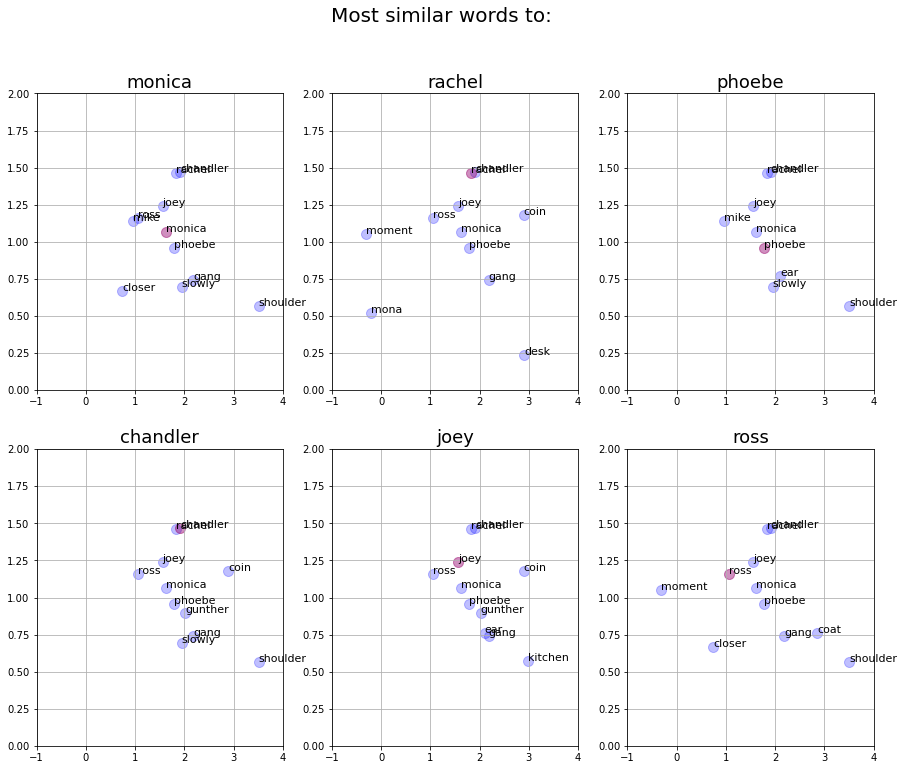

In [43]:
friends_characters = ['monica', 'rachel', 'phoebe', 'chandler', 'joey', 'ross']
plot_similar_words(friends_characters, friends_w2v_model_125, subplot_size = [2,3], xlim=[-1,4], ylim=[0,2])

### Relations

#### Similarity

How similar are two words?

In [23]:
# Get similarity matrix
word_list = ['chandler', 'joey', 'ross', 'monica', 'rachel', 'phoebe', 'man', 'woman', 'cool', 'child']
sim_matrix = get_similarity_matrix(friends_w2v_model_125, word_list)

<AxesSubplot:>

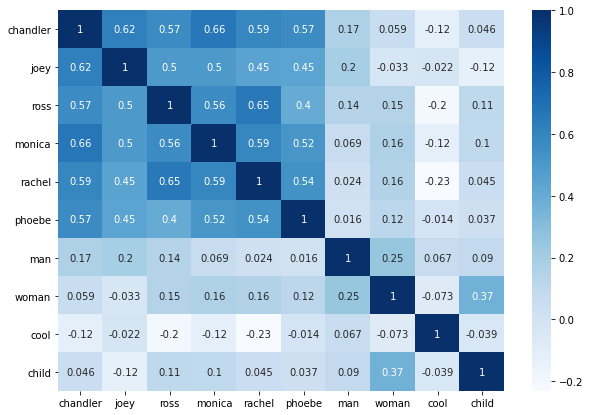

In [24]:
# Plot matrix
import seaborn as sn
sim_df = pd.DataFrame(sim_matrix, index = [i for i in word_list],columns = [i for i in word_list])
plt.figure(figsize = (10,7))
sn.heatmap(sim_df, annot=True, cmap='Blues')

#### Analogy

Which word is to $w_4$ as $w_1$ is to $w_2$?

In [25]:
friends_w2v_model_125.wv.most_similar(positive=["woman", "rachel"], negative=['man'], topn=5)

[('monica', 0.4152609705924988),
 ('suddenly', 0.398446261882782),
 ('ross', 0.39690762758255005),
 ('gang', 0.389098584651947),
 ('slowly', 0.3875057101249695)]

#### Doesn't Match

Which word doesn't match?

In [26]:
friends_w2v_model_25.wv.doesnt_match(['chandler', 'joey', 'ross', 'monica', 'rachel', 'phoebe'])

C:\Users\CESAR\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'phoebe'